In [1]:
##Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.spatial.distance import pdist, squareform

## Context


If you like to read you know the bittersweet feeling of finishing a book, specially if you loved it. The happiness of having enjoyed a good story gets mixed with the sadness of leaving it behind, and the longing of finding new adventure partners to fill the void. However, choosing is not always easy, is it? 

Being an avid reader and a newbie data analyst, I thought about diving a little bit more into the matter and try to find some ways of getting new interesting recommendations that could fulfill me. 

## Where to start: the data

The dataset goodbooks-10k, put together by Zygmunt Zajac, seemed a very good starting point for the analysis. It contains several CSV that contain, amongst other, the following information:

- Ratings: rating value per user and book
- Books: information on the books in the dataset, such as title, author, etc
- Tags: user-generated tags related to the books

The information is gathered from the Goodreads website.

#### Ratings

The ratings CSV contains 5976479 unique ratings, created by 53424 unique users on 10000 unique books. The data can be matched to  the information on the books CSV using the 'book_id' key.

<img style="float: centre;" src="screenshots/ratings_table.JPG" width="600"/>

#### Books

The books table contains 10000 unique entries, each one containing information about the book. After some inspection of the data, the following rows are kept:

- book_id: used as foreign key in the ratings table
- goodreads_book_id: used as foreign key in the tags table
- book_title: the title of the book, extracted from the original title column
- book_series: the series of the book (when part of a collection). Extracted from the original title column
- authors
- original_publication year: there are 21 missing values that are replaced by 0 to avoid NaN values.
- average_rating: the average rating of the book considering all users votes and all editions
- work_ratings_count: the total amount of user votes

<img style="float: centre;" src="screenshots/books_table.JPG" width="1200"/>

#### Tags

A first check on the descriptive statistics seems to indicate that keeping only a few tags we can provide some relevant extra information to our dataset. 

In [2]:
tags = pd.read_csv('datasets/gb10k_tags.csv')
books_tags = pd.read_csv('datasets/gb10k_book_tags.csv')
books_with_tags = pd.merge(books_tags, tags, on=['tag_id'])
books_per_tag = books_with_tags.groupby(['tag_id', 'tag_name'], as_index=False).count().drop(columns=['count']).rename(columns={'goodreads_book_id':'number_of_books'}).sort_values(by=['number_of_books'], ascending=False).reset_index(drop=True)
books_per_tag.describe()

,tag_id,number_of_books
count,34252.000000,34252.000000
mean,17125.500000,29.192806
std,9887.845047,277.254715
min,0.000000,1.000000
25%,8562.750000,1.000000
50%,17125.500000,1.000000
75%,25688.250000,5.000000
max,34251.000000,9983.000000


This is interesting as the tags are user generated and therefore will need to be manually reviewed and somehow normalized, a task that will prove very difficult for the total amount of tags (34252). However, we can see that more than more than 75% of our tags are associated to only 5 books at most. We can also see that the mean of books per tag is 30, which along with the previous data indicates that probaby there are a few outliers in our tags dataset that concentrate a lot of books. The following plot helps seeing that too:

<Figure size 720x288 with 0 Axes>

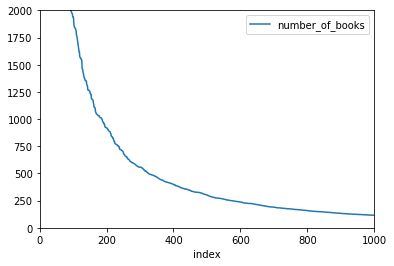

In [3]:
plt.figure(figsize=(10,4))
books_per_tag.reset_index().plot(x='index', y='number_of_books')
plt.ylim(0,2000)
plt.xlim(0,1000)
plt.show()

There seems to be quite a long tail in the tags, so roughly 200 tags qualify most of the books, and after that threshold tags seem to qualify only a small amount of books each. In order to make a final decision, it would be interesting to also check if ignoring that subset of tags will leave books underqualified:

In [4]:
number_of_tagged_books = [1500, 1250, 1000, 750, 500, 250]
for i in number_of_tagged_books:
    reduced_books_per_tag = books_per_tag.copy()
    reduced_books_per_tag = reduced_books_per_tag[reduced_books_per_tag.number_of_books > i]
    list_of_tags = reduced_books_per_tag.tag_id.unique().tolist()
    books_with_tags_reduced = books_with_tags.copy()
    books_with_tags_reduced = books_with_tags_reduced[books_with_tags_reduced.tag_id.isin(list_of_tags)]
    tags_per_book = books_with_tags_reduced.groupby(['goodreads_book_id'], as_index=False).count().drop(columns=['count', 'tag_name']).rename(columns={'tag_id':'number_of_tags'}).sort_values(by=['number_of_tags'], ascending=True).reset_index(drop=True)
    print('If we keep the most used', len(list_of_tags), 'tags, the less qualified book will have', tags_per_book.iloc[0, 1], 'related tags.')

If we keep the most used 127 tags, the less qualified book will have 10 related tags.
If we keep the most used 151 tags, the less qualified book will have 11 related tags.
If we keep the most used 186 tags, the less qualified book will have 12 related tags.
If we keep the most used 237 tags, the less qualified book will have 14 related tags.
If we keep the most used 325 tags, the less qualified book will have 17 related tags.
If we keep the most used 572 tags, the less qualified book will have 17 related tags.


The previous code proves that even with as little as 127 tags, all books will at least be related to 10 tags. Therefore only the most used 150 tags were taken into account for manual review. The cleaning process of the tags included several actions:

- Create consistency between tags, editing the ones that meant the same (i.e.: 'fantasy-sci-fi' and 'sci-fi-fantasy')
- Simplify tags when they refer to equal or similar concepts (i.e.: 'owned-books' and 'books-i-own')
- Classify tags according to it's content, as that may be important in the future analysis (i.e.: genre tags, status tags and type tags)
- Discard tags that seemed not relevant for the analysis (i.e.: 'literature')

The reviewed tags were merged with the original book-tag dataframe. The discarded tags, as well as the other long tail tags not considered in the review, were set to a general category.

<img style="float: centre;" src="screenshots/tags_table.JPG" width="500"/>

## Exploratory Data Analysis

### Some insights on the ratings table


Number of users: 53424
Maximum amount of ratings per users: 200.0
Average amount of ratings per user: 111.86880428271938
Minimum amount of ratings per users: 19.0
Number of users with more than 100 reviews: 36199
Number of users with more than 50 reviews: 52485


Number of books: 10000
Maximum amount of ratings per book: 22806.0
Average amount of ratings per book: 597.6479
Minimum amount of ratings per book: 8.0
Number of books with more than 100 reviews: 9484
Number of books with more than 50 reviews: 9990


Number of ratings: 5976479
5-star ratings: 33.181627510110886 %
4-star ratings: 35.790605137238835 %
3-star ratings: 22.938522832590895 %
2-star ratings: 6.011181500010291 %
1-star ratings: 2.078063020049096 %



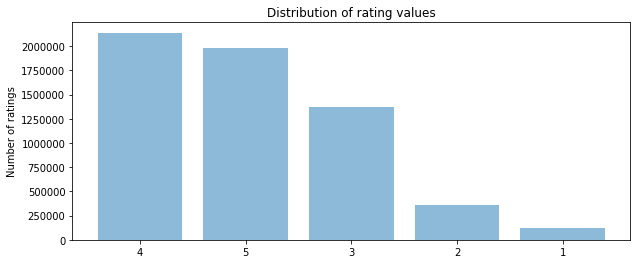

In [5]:
##Get some insights on the users
ratings = pd.read_csv('datasets/gb10k_ratings.csv')
ratings_by_user = ratings.groupby(['user_id'], as_index=False).count()
ratings_by_user = ratings_by_user.drop(columns=['rating']).rename(columns={'book_id':'number_of_ratings'}).sort_values(by=['number_of_ratings'], ascending=False)
print('')
print('Number of users:', len(ratings_by_user))
print('Maximum amount of ratings per users:', ratings_by_user.number_of_ratings.describe()['max'])
print('Average amount of ratings per user:', ratings_by_user.number_of_ratings.describe()['mean'])
print('Minimum amount of ratings per users:', ratings_by_user.number_of_ratings.describe()['min'])
print('Number of users with more than 100 reviews:', len(ratings_by_user[ratings_by_user.number_of_ratings > 100]))
print('Number of users with more than 50 reviews:', len(ratings_by_user[ratings_by_user.number_of_ratings > 50]))
print('')

##Get some insights on the books
ratings_by_book = ratings.groupby(['book_id'], as_index=False).count()
ratings_by_book = ratings_by_book.drop(columns=['rating']).rename(columns={'user_id':'number_of_ratings'}).sort_values(by=['number_of_ratings'], ascending=False)
print('')
print('Number of books:', len(ratings_by_book))
print('Maximum amount of ratings per book:', ratings_by_book.number_of_ratings.describe()['max'])
print('Average amount of ratings per book:', ratings_by_book.number_of_ratings.describe()['mean'])
print('Minimum amount of ratings per book:', ratings_by_book.number_of_ratings.describe()['min'])
print('Number of books with more than 100 reviews:', len(ratings_by_book[ratings_by_book.number_of_ratings > 100]))
print('Number of books with more than 50 reviews:', len(ratings_by_book[ratings_by_book.number_of_ratings > 50]))
print('')

##Get some insights on the ratings
ratings_distribution = ratings.groupby(['rating'], as_index=False).count()
ratings_distribution = ratings_distribution.drop(columns=['book_id']).rename(columns={'user_id':'number_of_ratings'}).sort_values(by=['number_of_ratings'], ascending=False)
ratings_distribution['percentage'] = ratings_distribution.number_of_ratings/ratings_distribution.number_of_ratings.sum(axis = 0)
print('')
print('Number of ratings:', ratings_distribution.number_of_ratings.sum(axis = 0))
print('5-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 5), 'percentage'].values[0])*100, '%')
print('4-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 4), 'percentage'].values[0])*100, '%')
print('3-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 3), 'percentage'].values[0])*100, '%')
print('2-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 2), 'percentage'].values[0])*100, '%')
print('1-star ratings:', (ratings_distribution.loc[(ratings_distribution.rating == 1), 'percentage'].values[0])*100, '%')
print('')

plt.figure(figsize=(10,4))

x = ratings_distribution.rating
y_pos = np.arange(len(x))
y = ratings_distribution.number_of_ratings

plt.bar(y_pos, y, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Number of ratings')
plt.title('Distribution of rating values')
plt.show()

In addition to the general numbers already perceived at first sight when exploring and cleaning the data, we can now add some extra insights to our analysis. In terms of the users, we can see that they are very active: 36199 of them gave more than 100 reviews, and 52485 gave more than 50 reviews. The minimum number of ratings per user is 19, a number that can be still considered valid to get some pattern about the user general taste.

If we evaluate the ratings per book, on the other hand, we can see that the dispersion is much higher: we can find books with as many as 22806 reviews, and others with as little as 8. However, 9484 books have more than 100 reviews, and 50% of the books have at least 248 reviews. A long tail in a database about books is expected, considering the amount of existing books in the world, but it also reflects the wide variety of behavioural patterns we can expect from our users.

The ratings in the dataset are not evenly distributed. Most of the books have a punctuation of 3 or more. 4 is the most common rating (35.79% of the ratings are 4). 4 and 5 star ratings add up to almost 70% of the total ratings.

### Some insights on the ratings table

After reducing the number of tags and categorizing them, we may take a closer look at each category to see what they reveal:

#### Exploring the 'genre' tags

In the manual exploration of the tags, I identified 3 different tag categories. The first one would be the 'genre' (tags that help qualify the content of the book somehow), the second one would be the 'book status' (meaning categorical information of the 'relation' reader-book, such as 'I would like to read this book' or 'I abandoned this book') and the third one would be the 'type' (related to the format of the book or other information on the origin of the book).

Let's take a quick look at the three categories, starting by the 'genre' tags. In the following plot we can see a representation of the total times a tag was used by any user on any book:

<img style="float: centre;" src="screenshots/most_used_genre_tags.png" width="400"/>

Moreover, the following bar plot shows the amount of books rated for every specific tag in our list:

<img style="float: centre;" src="screenshots/books_tagged_per_genre_tag.JPG" width="700"/>

The two main considerations to keep in mind would be: 

- The tags are created by the user, therefore they are not a perfect taxonomy. For instance, there are some that are quite generic (i.e: 'non-fiction') and others that can be considered a sub-genre of a genre (coming-to-age and young adult). 

- There is not a limit on the amount of tags that a user can relate to a book. Therefore, a book can be categorized in several genres.

As we can see below, some books will have as many as 32 of these genre tags while others may have as little as one.

In [6]:
all_books = pd.read_csv('datasets/clean_books.csv')
all_tags_books = pd.read_csv('datasets/clean_tags_books.csv')
books_all_info = pd.merge(all_tags_books, all_books, on='goodreads_book_id')

genres = books_all_info[books_all_info.tag_class == 'genre']
genres_per_book_count = genres[['goodreads_book_id', 'new_tag_name']].groupby(['goodreads_book_id'], as_index=False).count().rename(columns={'new_tag_name':'number_of_tags'})
genres_per_book_count
print('The book with more related tags has', genres_per_book_count.number_of_tags.max(), 'tags')
print('The book with less related tags has', genres_per_book_count.number_of_tags.min(), 'tags')

The book with more related tags has 32 tags
The book with less related tags has 1 tags


In [7]:
genres_per_book_count[genres_per_book_count.number_of_tags == genres_per_book_count.number_of_tags.max()]

,goodreads_book_id,number_of_tags
4660,284440,32
5686,862041,32
6951,7005865,32


In [8]:
genres_per_book = genres[['goodreads_book_id', 'book_title', 'new_tag_name', 'count']]
genres_per_book[genres_per_book.goodreads_book_id == 284440].sort_values('count', ascending=False).head(5)

,goodreads_book_id,book_title,new_tag_name,count
465695,284440,Skulduggery Pleasant,fantasy,1474
465698,284440,Skulduggery Pleasant,young adult,587
465734,284440,Skulduggery Pleasant,mystery,283
465702,284440,Skulduggery Pleasant,young adult,263
465709,284440,Skulduggery Pleasant,adventure,224


In [9]:
genres_per_book = genres[['goodreads_book_id', 'book_title', 'new_tag_name', 'count']]
genres_per_book[genres_per_book.goodreads_book_id == 862041].sort_values('count', ascending=False).head(5)

,goodreads_book_id,book_title,new_tag_name,count
568099,862041,Harry Potter Boxset,fiction,703
568095,862041,Harry Potter Boxset,fantasy,377
568103,862041,Harry Potter Boxset,young adult,336
568104,862041,Harry Potter Boxset,series,332
568110,862041,Harry Potter Boxset,adventure,198


In [10]:
genres_per_book = genres[['goodreads_book_id', 'book_title', 'new_tag_name', 'count']]
genres_per_book[genres_per_book.goodreads_book_id == 7005865].sort_values('count', ascending=False).head(5)

,goodreads_book_id,book_title,new_tag_name,count
694495,7005865,The Atlantis Complex,fantasy,483
694499,7005865,The Atlantis Complex,fiction,275
694502,7005865,The Atlantis Complex,young adult,254
694567,7005865,The Atlantis Complex,science-fiction,236
694503,7005865,The Atlantis Complex,series,208


Nevertheless, if we check at the tags related to each book, we can see that even when multiple genres are applied, there tends to be one or two that clearly prevail over the others. We will consider this information and use only the two more used tags per book to describe its genre, using the first one as main genre and the second one as secondary genre. The rest of tags will be discarded for the current analysis. 

#### Exploring the 'book status' tags

<img src="screenshots/most_used_status_tags.png" width="45%" style="display:inline;">
<div style="display:inline;width:200px;"></div>
<img src="screenshots/books_tagged_per_status_tag.JPG" width="45%" style="display:inline;">

We can see, on the first place, that the most used tag, by far, is 'to-read'. We can also see that all books have been tagged as 'to_read', 'owned' or 'favorites' by at least one user. 

Since the information is provided as an aggregated number of tags per book, an analysis on reading patterns based in this data is not possible. Moreover, we have to consider that these type of tags may not be edited as time goes by, therefore maybe not being accurate for this type of study even if we had the data recorded per book and user.

There is another layer of information, though, related to the user sentiment. For instance, books tagged as 'favourites' or 're-read' can be assigned to a positive sentiment of the user, while books rated as 'abandoned' can be rated as negative. 

In [11]:
status = books_all_info[books_all_info.tag_class == 'book_status']
status_per_book = status[['goodreads_book_id', 'new_tag_name', 'count', 'book_title']]
most_favorites = status_per_book[status_per_book.new_tag_name == 'favorites'].sort_values(by='count', ascending=False) 
most_favorites.head(10)

,goodreads_book_id,new_tag_name,count,book_title
618796,2767052,favorites,50755,The Hunger Games
202,3,favorites,48220,Harry Potter and the Sorcerer's Stone
388802,136251,favorites,40884,Harry Potter and the Deathly Hallows
302,5,favorites,40087,Harry Potter and the Prisoner of Azkaban
795395,11870085,favorites,35724,The Fault in Our Stars
2,1,favorites,34173,Harry Potter and the Half-Blood Prince
15201,1885,favorites,31163,Pride and Prejudice
19801,2657,favorites,30903,To Kill a Mockingbird
147802,19063,favorites,30427,The Book Thief
127602,15881,favorites,30279,Harry Potter and the Chamber of Secrets


In [12]:
most_unliked = status_per_book[status_per_book.new_tag_name == 'abandoned'].sort_values(by='count', ascending=False) 
most_unliked.head(10)

,goodreads_book_id,new_tag_name,count,book_title
90266,10964,abandoned,545,Outlander
411051,168668,abandoned,518,Catch-22
110666,13496,abandoned,514,A Game of Thrones
777634,10818853,abandoned,507,Fifty Shades of Grey
147862,19063,abandoned,466,The Book Thief
32865,4407,abandoned,455,American Gods
90265,10964,abandoned,441,Outlander
657633,6101138,abandoned,427,Wolf Hall
147866,19063,abandoned,422,The Book Thief
888038,17333223,abandoned,419,The Goldfinch


Though this information could be used to tweak a recommendation model, the systems that we will approach during this project will only take into consideration the information explicitly provided by the user as rating. Therefore, we will discard these tags for the time being.

#### Exploring the 'book type' tags

The tags classified as 'type tags' mostly refer to the physical format of the book, or other general classifications related to the source of the reading (i.e.: bookclub):


<img style="float: centre;" src="screenshots/most_used_type_tags.png" width="400"/>


This information could be interesting for statistical purposes, like understanding the penetration of new formats (e-book, audiobook) in the current population. However, that is beyond the purpose of this project, so we will also discard this information for the moment.

## Building a recommender system: basic recommendations

When considering how to provide recommendations to users, the most simple and obvious option is to go for the best and most popular products. These metrics can be easily found in our dataset:

- Popularity: we consider that the more ratings (work_rating_counts) a book gets, the more popular it is.
- Quality: we consider that the higher the average rating (average_rating) of a book is, the better it is. The average rating is calculated by multiplying the number of ratings of each value per that value and then dividing that number by the total amount of ratings.

#### Top 10 rated books

<img style="float: centre;" src="screenshots/Average_rating_per_book.png" width="1000"/>

#### Top 10 most popular books

<img style="float: centre;" src="screenshots/Number of ratings per book.png" width="1000"/>

When we check at this first analysis, we can see that the list of 'best' books may not be the one we expected. This is because the average rating metric normally penalizes the books with more total ratings. Let's check, for instance, the first  book in each list:

In [13]:

all_books.drop(columns=['Unnamed: 0'], inplace=True)
most_popular = all_books[['goodreads_book_id', 'book_title', 'work_ratings_count', 'average_rating', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sort_values(by='work_ratings_count', ascending=False)
most_popular.head(1)

,goodreads_book_id,book_title,work_ratings_count,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,2767052,The Hunger Games,4942365,4.34,66715,127936,560092,1481305,2706317


In [14]:
most_rated = all_books[['goodreads_book_id', 'book_title', 'work_ratings_count', 'average_rating', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',]].sort_values(by='average_rating', ascending=False)
most_rated.head(1)

,goodreads_book_id,book_title,work_ratings_count,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
3627,24812,The Complete Calvin and Hobbes,29968,4.82,120,154,693,3117,25884


In [15]:
print('')
print('The Hunger Games 5-star rating percentage over total is', (most_rated.loc[0,'ratings_5']/most_rated.loc[0,'work_ratings_count'])*100)
print('The Complete Calvin and Hobbes 5-star rating percentage over total is', (most_rated.loc[3627,'ratings_5']/most_rated.loc[3627,'work_ratings_count'])*100)


The Hunger Games 5-star rating percentage over total is 54.75753004887336
The Complete Calvin and Hobbes 5-star rating percentage over total is 86.37213027229045


Even though the percentage of users over the total that rated The Hunger Games with 5-stars is less than the one for The Complete Calvin and Hobbes, the total amount of people that rated The Hunger Games with 5-stars is much higher than the one for The Complete Calvin and Hobbes. Therefore, an algorithm that calculates a recommendation based on popularity and quality should take that into consideration. 

We are going to consider a weighted algorithm:

<img style="float: left;" src="screenshots/formula.JPG" width="400"/>

where:
- v is the number of ratings that the book has (nr in the code)
- m is the minimum votes required to be listed (mv in the code)
- R is the average rating of the book (ar in the code)
- C is the mean rating across the whole dataset (mr in the code)

Here the value for mv is the element we can tune in order to decide how much we let our elements with low ratings to affect our final results. In this case, considering the distribution in the number of ratings, we consider a 90th percentile (meaning that in order for a book to be recommended, it needs to have more votes than at least 90% of the books). 

In [16]:
# Create a function to calculate the weighted rating
def w_rating(row, mv, mr):
    nr = row.work_ratings_count
    ar = row.average_rating
    return (nr/(nr+mv) * ar) + (mv/(mv+nr) * mr)

# Create a function to calculate a recommendation for all genres
def basic_recommendation(dataset, mv, mr):
    books_to_evaluate = dataset.copy()
    
    ## Choose the subset of books to evaluate
    books_to_evaluate = books_to_evaluate[books_to_evaluate.work_ratings_count >= mv]
    
    ## Calculate weighted rating and order the list of recommended books by that value
    books_to_evaluate['w_rating'] = books_to_evaluate.apply(lambda x : w_rating(x, mv, mr), axis=1)
    books_to_evaluate = books_to_evaluate.sort_values(by='w_rating', ascending=False)
    return books_to_evaluate[['book_title','book_series','w_rating', 'authors', 'main_genre']].set_index('book_series')


##Set main parameters
all_books_cat = pd.read_csv('datasets/work_datasets/books_with_category.csv')
mv = all_books_cat['work_ratings_count'].quantile(0.90)
mr = all_books_cat['average_rating'].mean()

general_recommendations = basic_recommendation(all_books_cat, mv, mr)
general_recommendations.head(10)

,book_title,w_rating,authors,main_genre
book_series,,,,
Harry Potter,Harry Potter and the Deathly Hallows,4.577047,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter and the Half-Blood Prince,4.509888,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter and the Prisoner of Azkaban,4.503064,"J.K. Rowling, Mary GrandPré, Rufus Beck",fantasy
Harry Potter,Harry Potter and the Goblet of Fire,4.501689,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter Boxset,4.487955,J.K. Rowling,fantasy
A Song of Ice and Fire,A Storm of Swords,4.450089,George R.R. Martin,fantasy
The Kingkiller Chronicle,The Name of the Wind,4.445507,Patrick Rothfuss,fantasy
Harry Potter,Harry Potter and the Order of the Phoenix,4.435087,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter and the Sorcerer's Stone,4.430547,"J.K. Rowling, Mary GrandPré",fantasy


This results show more balance between popularity and perceived quality, but we can quickly see that they are far from perfect. For instance, we can see that the first five results are part of the Harry Potter series, and for the user that can be frustrating, as it does not offer wide variety.

A possible way to tweak these results into a more varied ones would be to show only the first result of a series and drop the rest:

In [17]:
# Modify the function to exclude books from the same series
def basic_recommendation_exclude_series(dataset, mv, mr):
    books_to_evaluate = dataset.copy()
    
    ## Choose the subset of books to evaluate
    books_to_evaluate = books_to_evaluate[books_to_evaluate.work_ratings_count >= mv]
    
    ## Calculate weighted rating and order the list of recommended books by that value
    books_to_evaluate['w_rating'] = books_to_evaluate.apply(lambda x : w_rating(x, mv, mr), axis=1)
    books_to_evaluate = books_to_evaluate.sort_values(by='w_rating', ascending=False)
    
    ## Take out from the dataframe books from the same series, keeping only the highest rated one
    grouped = books_to_evaluate[['book_title','book_series','w_rating', 'authors', 'main_genre']].set_index('book_series')
    grouped = grouped.loc[~grouped.index.duplicated(keep='first')]
    return grouped

recommendations_no_series = basic_recommendation_exclude_series(all_books_cat, mv, mr)
recommendations_no_series.head(10)

,book_title,w_rating,authors,main_genre
book_series,,,,
Harry Potter,Harry Potter and the Deathly Hallows,4.577047,"J.K. Rowling, Mary GrandPré",fantasy
A Song of Ice and Fire,A Storm of Swords,4.450089,George R.R. Martin,fantasy
The Kingkiller Chronicle,The Name of the Wind,4.445507,Patrick Rothfuss,fantasy
The Lord of the Rings,The Return of the King,4.422745,J.R.R. Tolkien,fantasy
NaN,The Help,4.422252,Kathryn Stockett,historical
The Infernal Devices,Clockwork Princess,4.414067,Cassandra Clare,fantasy
Percy Jackson and the Olympians,The Last Olympian,4.412904,Rick Riordan,fantasy
A Court of Thorns and Roses,A Court of Mist and Fury,4.392844,Sarah J. Maas,fantasy
The Stormlight Archive,The Way of Kings,4.390141,Brandon Sanderson,fantasy


This is already an improvement, but is also proves the bias we already noticed when analyzing the data provided in the dataset: Goodread users seem to love the fantasy genre! 

In case our user is not a fan, though, it would be interesting to offer the top titles for a certain category:

In [18]:
# Modify the function to include category
def recommendation_with_category(dataset, mv, mr, genre=None):
    if genre ==None: 
        books_to_evaluate = dataset.copy()
    else:
        books_to_evaluate = dataset.copy()
        books_to_evaluate = books_to_evaluate[books_to_evaluate.main_genre == genre]
    
    ## Choose the subset of books to evaluate
    books_to_evaluate = books_to_evaluate[books_to_evaluate.work_ratings_count >= mv]
    
    ## Calculate weighted rating and order the list of recommended books by that value
    books_to_evaluate['w_rating'] = books_to_evaluate.apply(lambda x : w_rating(x, mv, mr), axis=1)
    books_to_evaluate = books_to_evaluate.sort_values(by='w_rating', ascending=False)
    
    ## Take out from the dataframe books from the same series, keeping only the highest rated one
    grouped = books_to_evaluate[['book_title','book_series','w_rating', 'authors', 'main_genre']].set_index('book_series')
    grouped = grouped.loc[~grouped.index.duplicated(keep='first')]
    return grouped

recommendations_young_adult = recommendation_with_category(all_books_cat, mv, mr, 'young adult')
recommendations_young_adult.head(10)

,book_title,w_rating,authors,main_genre
book_series,,,,
NaN,Wonder,4.336303,R.J. Palacio,young adult
The Hunger Games,The Hunger Games,4.332910,Suzanne Collins,young adult
Throne of Glass,Crown of Midnight,4.311980,Sarah J. Maas,young adult
The Lunar Chronicles,Cress,4.288842,Marissa Meyer,young adult
Vampire Academy,Last Sacrifice,4.283191,Richelle Mead,young adult
Divergent,Divergent,4.229148,Veronica Roth,young adult
Legend,Champion,4.199945,Marie Lu,young adult
Anne of Green Gables,Anne of Green Gables,4.192223,L.M. Montgomery,young adult
Slammed,Slammed,4.181855,Colleen Hoover,young adult


These type of recommendations can provide some interesting insights to the user, and we can also adjust some parameters, like the minimum votes (mv) or the number of results returned, in order to get other different recommendations with the guarantee of a certain degree of quality.

The system, though, has one very big drawback, which we can call the dictatorship of the majority. In that sense, as only books that include a certain number of votes are considered, the most popular books are clearly beneffited from the system, and as they get more recommended, they are more read and also more voted, perpetuating the circle. 

In order to avoid this we could transform our 5-star voting system into a 'positive'/'negative' system and apply the formula suggested by Evan Miller [in this post](http://https://www.evanmiller.org/how-not-to-sort-by-average-rating.html/), which seeks to correct this bias. However, we saw in our analysis that the amount of positive votes in our system is much higher than the negative ones, a factor that could bias this type of approach. Moreover, since we have access to the unique ratings of the different users, we can try a different and more personalized appoach by exploring the proximity between users.

## Building a recommender system: collaborative filtering

As long as we have enough information about our users, we can approach the creation of a recommender system using the technique of collaborative filtering. As Wikipedia describes it, *collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.*

There are two main approaches to collaborative filtering: User-Based Collaborative Filtering (UB-CF) and Item-Based Collaborative Filtering (IB-CF). Both of them rely on calculating proximity correlations based on the user's behaviour.

### User-based Collaborative Filtering

<img style="float: left;" src="screenshots/ub_cf.png" width="400"/>

A user-based collaborative filtering system compares the behaviour of the user (being that the products purchased, the contents viewed or, in this case, the books rated) to the rest of users in the dataset, and searches for the most similar users based on that behaviour. Then it checks the products consumed by these similar users and recommends to the first user the ones that he/she has not tried yet.

### Building a user-based colaborative filtering recommender

In order to build UB-CF recommender, the first thing we will have to do is create a correlation matrix between this user and all the rest of users in our dataset. For the purpose of this project, I have separated 50 users from our ratings dataset, which are going to be our test group, meaning the users we will be providing recommendations to. 

The rest of the users in the dataset can all potentially be used in our correlation matrix to help predict recommendations. However, due to the computational cost of including all 53374 users, a subset of 5000 was considered here. The parameter can be easily changed in the code if desired.

In [19]:
## Create a sample group of 50 users that will serve to try the recommender
all_ratings = pd.read_csv('datasets/gb10k_ratings.csv')
random.seed(42)
random_users=random.sample(list(all_ratings['user_id'].unique()),50)
my_test_group = all_ratings.loc[all_ratings['user_id'].isin(random_users)]
my_train_data = all_ratings.loc[~all_ratings['user_id'].isin(random_users)]

In [20]:
## Create a function that returns a list of 5 most similar users for the user given.

def give_me_closest_users(train_dataframe, my_user_df):
    
    ##Extract the user id of the dataframe with all his/her info for further reference
    my_user_id = my_user_df.user_id.unique()[0]
    
    ##Select a list of random ids from our train dataset to create the correlation matrix with our user
    random_train_ids = random.sample(list(train_dataframe['user_id'].unique()),5000)
    
    ##Create a dataframe with the rating information of the randomly selected users
    train_df = train_dataframe[train_dataframe['user_id'].isin(random_train_ids)]
    
    ##Merge the ratings of our user with all the ratings of the previous dataframe
    train_df_and_user = pd.concat([train_df, my_user_df], ignore_index=True)
    
    ##Create a pivot table of the dataframe
    pv_data = train_df_and_user.pivot_table(index=['user_id'], columns=['book_id'], values=['rating'], fill_value=0) 
    
    ##Normalize the values of the dataframe
    pv_data = pv_data.div(pv_data.sum(axis=1), axis=0)
    
    ##Create a user matrix that measures the correlation between users
    user_matrix = pd.DataFrame(1/ (1 + squareform(pdist(pv_data, metric = 'Euclidean'))), columns = pv_data.index, index = pv_data.index)

    ##Return a list of the 5 more related users. The first correlation of the list is excluded as it will be our target user
    return list(user_matrix[my_user_id].sort_values(ascending=False)[1:6].index)

Given a dataframe with all the ratings of a user, the previous function is going to calculate a correlation matrix between this user and the other users and extract the 5 users more similar to ours. Once we have that list of similar users, we will extract a list of all the books they have rated and substract from that list the ones that are already rated by our user. Finally, we will select a subset of those books to recommend to our user (the number of elements can be selected on the function parameters):

In [21]:
##Create a function that returns list of books read by the most similar users, minus the ones already read by the user.
##The number of books will be indicated as a parameter
def give_books_id(ratings_df, my_user_df, similar_users, number_of_output_books):
    
    ##Extract all the books rated by the similar users
    recommended_books = ratings_df[ratings_df['user_id'].isin(similar_users)]
    
    ##Group all the books rated by the similar users and calculate the mean rating given by those users
    grouped = recommended_books.groupby('book_id', as_index=False).agg({'rating':'mean'})
    
    ##Create a list of the books read (rated) by our user
    list_of_books = my_user_df.book_id.tolist()
    
    ##Substract from all the books the ones already read (rated) by our user and order by rating
    grouped = grouped.loc[~grouped['book_id'].isin(list_of_books)]
    
    ##Select the amount of recommendations requested
    if len(grouped) > number_of_output_books:
        i = number_of_output_books
    else:
        i = len(recommended_books_id)
    final_df = (grouped.sort_values(by='rating', ascending=False).reset_index(drop=True))[0:i]
    return final_df

And with these steps, we have built a system that provides some book recommendations based on the user similarity to other users. Let's now explore the possibility of buiding an Item-based recommender system instead.

### Item-based Collaborative Filtering

<img style="float: left;" src="screenshots/ib_cf.png" width="400"/>

An item-based collaborative filtering system compares the similarity of the items in terms of the user behaviour. That means that items rated (or purchased, or viewed) similarly by users will be considered also similar. Let's say, for instance, that users A, B and C rated very highly one book. Also, users A and B rated very highly a second book. The ststem will then consider that this second book is a suitable recommendation for user C.

### Building an item-based colaborative filtering recommender

Considering this premise, the first thing we will need to do in order to build an item-based recommender is to calculate a correlation matrix among the books in our dataset. The steps to do so are the same used above to get the user correlation matrix.

Since the time to compute it is quite high, though, I decided to run the code beforehand and import in this notebook the final result. The code used for the creation of the matrix can be found in my Github under the 'notebooks' folder, and the final matrix, if wanted, can be downloaded [here](https://drive.google.com/file/d/1lH_W5JJX6fLILbttpRW6VvDhhS-oWGIg/view?usp=sharing).

*Note: please note that the following import cell will not work if you run it without downloading the file*.

In [22]:
#Import books correlation matrix
books_corr = pd.read_csv('datasets/correlation_matrix/book_distance.csv')
books_corr.drop(columns=['book_id'], inplace=True)

Now that we have calculated how close each book in our dataset is to the others, we only need to compare the list of books that our user previously liked to that list, and extract from there other similar books that he may also like. We will set the threshold of 'books the user liked' on books rated 5 or 4, unless he did not rate any books with that score, in which case we will include the books rated with a 3.

In [23]:
def get_most_similar_book_ids(my_user_df, books_corr, number_of_output_books):
    
    ## Select the books to be considered
    if (my_user_df.rating == 5).sum() == 0 and (my_user_df.rating == 4).sum() == 0:
        selected_ratings = my_user_df[(my_user_df.rating == 3)]
    else:
        selected_ratings = my_user_df[(my_user_df.rating == 5) | (my_user_df.rating == 4)]
    
    ## Create a list with those books id
    user_book_ids = selected_ratings.book_id.unique().tolist()
    
    ## Look for similar books on our correlation matrix
    list_similar_books = []
    for book in user_book_ids:
        similar_books = list(books_corr.loc[book-1].sort_values(ascending=False)[1:6].index)
        list_similar_books.append(similar_books)
    
    ## Flatten the list obtained and remove duplicates. Convert the elements of the list to integers
    flat_list = list(set([item for nested_list in list_similar_books for item in nested_list]))
    int_list = list(map(int, flat_list))
    
    ## Remove the books already rated by the user
    all_user_book_ids = my_user_df.book_id.unique().tolist()
    final_list = [x for x in int_list if x not in all_user_book_ids]
    
    ##Select the amount of recommendations requested
    if len(final_list) > number_of_output_books:
        i = number_of_output_books
    else:
        i = len(final_list)    
    return final_list[:i]

### Getting recommendations

Now we can test both recommenders and see their results. Let's take one of our test users, for instance, 21451, and request recommendations for them:

In [24]:
user_ratings_df = my_test_group.loc[my_test_group.user_id == 21451]

In [25]:
##Launch the UB-CF
## Get a list of 5 similar users
similar_users = give_me_closest_users(my_train_data, user_ratings_df)
## Get the ids of all the possible books to recommend 
recommended_books_ub_id = give_books_id(all_ratings, user_ratings_df, similar_users, 10)

In [26]:
##Launch the IB-CF
## Get the ids of all the possible similar books
recommended_books_ib_id = get_most_similar_book_ids(user_ratings_df, books_corr, 10)

Now, let's compare the original list of books that the user has already rated with our recommender results:

In [27]:
##Create a df with all the book info
def get_books_info(df_series):
    books_basic_info = all_books[['book_id', 'book_title', 'book_series', 'authors']]
    books_genre = all_books_cat[['book_id', 'main_genre', 'sec_genre']]
    books_to_check = pd.merge(df_series, books_basic_info, how='left', on='book_id')
    books_to_check = pd.merge(books_to_check, books_genre, how='left', on='book_id')
    return books_to_check

**Books already rated by the user**

In [28]:
pd.set_option('display.max_rows', None)
books_already_read = user_ratings_df.drop(columns=['user_id'])
books_already_read = books_already_read.sort_values(by='rating', ascending=False)
info_books = get_books_info(books_already_read.book_id)
books_already_read_final = pd.merge(books_already_read, info_books, how='left', on='book_id')
books_already_read_final

,book_id,rating,book_title,book_series,authors,main_genre,sec_genre
0,2463,5,The False Prince,The Ascendance Trilogy #1),Jennifer A. Nielsen,fantasy,young adult
1,569,5,The Angel Experiment,Maximum Ride,James Patterson,young adult,fantasy
2,41,5,The Lightning Thief,Percy Jackson and the Olympians,Rick Riordan,fantasy,young adult
3,837,5,Every Day,Every Day,David Levithan,young adult,romance
4,2968,5,The Merchant of Death,Pendragon,D.J. MacHale,young adult,fantasy
5,149,5,If I Stay,If I Stay,Gayle Forman,young adult,young adult
6,1745,5,Leviathan,Leviathan,Scott Westerfeld,young adult,fantasy
7,355,5,Graceling,Graceling Realm,Kristin Cashore,fantasy,young adult
8,2816,5,Tiger's Curse,The Tiger Saga,Colleen Houck,fantasy,young adult
9,3238,5,Beauty Queens,NaN,Libba Bray,young adult,young adult


**Books recommended by the User-Based Collaborative Filtering Algorithm**

In [29]:
recommended_books_ub_final = get_books_info(recommended_books_ub_id.book_id)
recommended_books_ub_final

,book_id,book_title,book_series,authors,main_genre,sec_genre
0,4,To Kill a Mockingbird,NaN,Harper Lee,classic,classic
1,2389,Scorpia,Alex Rider,Anthony Horowitz,young adult,adventure
2,2019,The Maze of Bones,The 39 Clues,Rick Riordan,mystery,adventure
3,2072,Burned,Burned,Ellen Hopkins,young adult,young adult
4,2092,Identical,NaN,Ellen Hopkins,young adult,young adult
5,2194,Lady Midnight,The Dark Artifices,Cassandra Clare,romance,fantasy
6,2195,Inkdeath,Inkworld,Cornelia Funke,young adult,young adult
7,2200,Into the Gauntlet,The 39 Clues,Margaret Peterson Haddix,mystery,adventure
8,2212,The Confession,NaN,John Grisham,mystery,thriller
9,2282,Max,Maximum Ride,James Patterson,young adult,fantasy


**Books recommended by the Item-Based Collaborative Filtering Algorithm**

In [30]:
recommended_books_ib_id_df = pd.DataFrame(recommended_books_ib_id, columns =['book_id']) 
recommended_books_ib_final = get_books_info(recommended_books_ib_id_df.book_id)
recommended_books_ib_final

,book_id,book_title,book_series,authors,main_genre,sec_genre
0,3879,Just One Year,Just One Day,Gayle Forman,young adult,romance
1,5660,Shades of Earth,Across the Universe,Beth Revis,young adult,science-fiction
2,6133,The Reality Bug,Pendragon,D.J. MacHale,fantasy,young adult
3,6765,Once Upon a Marigold,Upon a Marigold,Jean Ferris,fantasy,young adult
4,667,Along for the Ride,NaN,Sarah Dessen,young adult,romance
5,74,Looking for Alaska,NaN,John Green,young adult,young adult
6,9471,Staying Fat for Sarah Byrnes,NaN,Chris Crutcher,young adult,young adult
7,275,An Abundance of Katherines,NaN,John Green,young adult,young adult
8,1231,Loving Frank,NaN,Nancy Horan,historical,historical
9,2974,Angel,Maximum Ride,James Patterson,young adult,fantasy


### Conclusions and next steps

There are multiple options to approach the problem of recommending content to our users. This first approach already shows some  possibilities, but there is still a lot of opportunities to explore. Some of the ones that I would like to consider in the future are:

- Combine both approaches studied in the project, in order to properly weight the results provided by the Collaborative Filtering algorithms before selecting the final 'n' elements to recommend to the user.
- Try an approach at a content-based recommendation, using the meta-information on the books already in the current dataset and also the descriptions of the books, which can be extracted via the Goodreads API (more on that soon).

I would also like to put to test the results of the recommender. As the taste of a user is something very personal, the success of future recommendations is always difficult to predict. A possible approach comparing the current algorithm predictions to already known ratings of the user, in order to check its accuracy. However, due to the sparcity of the data, the results may not be suitable even if the recommendations are valid. Another possible approach would be using feedback on the recommendations (i.e.: new ratings on the recommended books) to further train our algorithm.